**This CGAN is modified from the DCGAN in this PyTorch Tutorial.** Link: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [42]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [43]:
torch.manual_seed(0)

**Hyperparameter**

In [44]:
# Root directory for dataset
dataroot = "content/mnist"

# Number of workers for dataloader
workers = 10

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Number of classes in the training images. For mnist dataset this is 10
num_classes = 10

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


**Load Data**

In [24]:
train_data = datasets.MNIST(
    root=dataroot,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    download=True
)
test_data = datasets.MNIST(
    root=dataroot,
    train=False,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
dataset = train_data+test_data
print(f'Total Size of Dataset: {len(dataset)}')

Total Size of Dataset: 70000


In [25]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')
print(device)

cuda:0


**Weight Initialization**

In [27]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Visualization**

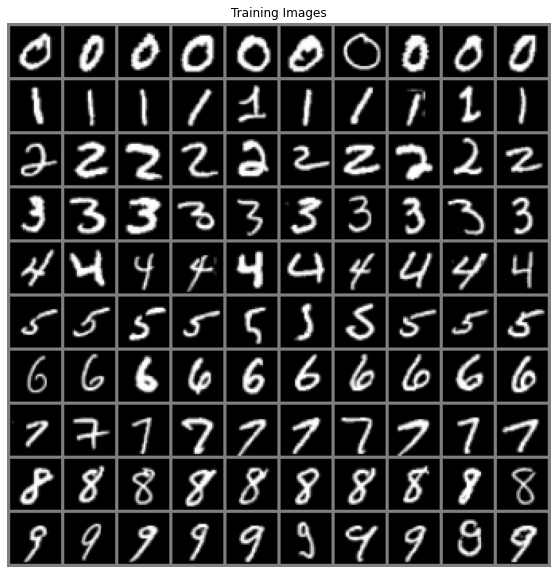

In [28]:
imgs = {}
for x, y in dataset:
    if y not in imgs:
        imgs[y] = []
    elif len(imgs[y])!=10:
        imgs[y].append(x)
    elif sum(len(imgs[key]) for key in imgs)==100:
        break
    else:
        continue
        
imgs = sorted(imgs.items(), key=lambda x:x[0])
imgs = [torch.stack(item[1], dim=0) for item in imgs]
imgs = torch.cat(imgs, dim=0)

plt.figure(figsize=(10,10))
plt.title("Training Images")
plt.axis('off')
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0)*0.5+0.5)


**Discriminator**

In [45]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.image = nn.Sequential(
        nn.Conv2d(nc, ndf, 4,2,1,bias=False),
        nn.LeakyReLU(0.2, inplace=True),
    )
    self.label = nn.Sequential(
        nn.Conv2d(num_classes, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.main = nn.Sequential(
        nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

    def forward(self, image, label):
      image = self.image(image)
      label = self.label(label)
      input = torch.cat((image, label), dim=1)
      return self.main(input)

In [47]:
netD = Discriminator(ngpu).to(device)

if device.type == 'cuda' and ngpu > 1:
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2
netD.apply(weights_init)

Discriminator(
  (image): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (label): Sequential(
    (0): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

**Generator**

In [31]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.image = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True)
    )
    self.label = nn.Sequential(
        nn.ConvTranspose2d(num_classes, ngf*4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True)
    )
    self.main = nn.Sequential(
        nn.Conv2d(ndf*8, ndf*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.ReLU(inplace=True),

        nn.Conv2d(ndf*4, ndf*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(ndf*2, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )
  
  def forward(self, image, label):
    image = self.image(image)
    label = self.label(label)
    input = torch.cat((image,label), dim=1)
    return self.main(input)

In [32]:
netG = Generator(ngpu).to(device)

if device.type == 'cuda' and ngpu > 1:
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

Generator(
  (image): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (label): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

**Loss and Optimizer**

In [33]:
loss_func = nn.BCELoss()

In [34]:
real_label = 1
fake_label = 0

In [35]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [36]:
# Label one-hot for G
label_1hots = torch.zeros(10,10)
for i in range(10):
    label_1hots[i,i] = 1
label_1hots = label_1hots.view(10,10,1,1).to(device)

In [37]:
label_fills = torch.zeros(10, 10, image_size, image_size)
ones = torch.ones(image_size, image_size)
for i in range(10):
    label_fills[i][i] = ones
label_fills = label_fills.to(device)

In [38]:
# Create batch of latent vectors and laebls that we will use to visualize the progression of the generator
fixed_noise = torch.randn(100, nz, 1, 1).to(device)
fixed_label = label_1hots[torch.arange(10).repeat(10).sort().values]

**Training**

In [39]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_x_list = []
D_z_list = []
loss_tep = 10

In [53]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):

    beg_time = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        # Format batch
        real_image = data[0].to(device)
        b_size = real_image.size(0)

        real_label = torch.full((b_size,), 1).to(device)
        fake_label = torch.full((b_size,), 0).to(device)
        
        G_label = label_1hots[data[1]]
        D_label = label_fills[data[1]]
        
        
        # Forward pass real batch through D
        output = netD(real_image, D_label).view(-1)
        # Calculate loss on all-real batch
        errD_real = loss_func(output, real_label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1).to(device)
        # Generate fake image batch with G
        fake = netG(noise, G_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), D_label).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_func(output, fake_label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, D_label).view(-1)
        # Calculate G's loss based on this output
        errG = loss_func(output, real_label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        end_time = time.time()
        run_time = round(end_time-beg_time)
        print(
            f'Epoch: [{epoch+1:0>{len(str(num_epochs))}}/{num_epochs}]',
            f'Step: [{i+1:0>{len(str(len(dataloader)))}}/{len(dataloader)}]',
            f'Loss-D: {errD.item():.4f}',
            f'Loss-G: {errG.item():.4f}',
            f'D(x): {D_x:.4f}',
            f'D(G(z)): [{D_G_z1:.4f}/{D_G_z2:.4f}]',
            f'Time: {run_time}s',
            end='\r'
        )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Save D(X) and D(G(z)) for plotting later
        D_x_list.append(D_x)
        D_z_list.append(D_G_z2)
        
        # Save the Best Model
        if errG < loss_tep:
            torch.save(netG.state_dict(), 'model.pt')
            loss_tep = errG

    # Check how the generator is doing by saving G's output on fixed_noise and fixed_label
    with torch.no_grad():
        fake = netG(fixed_noise, fixed_label).detach().cpu()
    img_list.append(utils.make_grid(fake, nrow=10))
    
    # Next line
    print()

Starting Training Loop...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

NotImplementedError: ignored